<div align="center">
  <h1 style="color:darkblue">🚀 Análise de Tweets durante a Covid-19🐦</h1>
  <img src="https://images.unsplash.com/photo-1593007791459-4b05e1158229?q=80&w=2070&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" alt="Emojis feliz desenhado no asfalto com a mensagem 'STAY SAFE'" width="20%">
  <img src="https://images.unsplash.com/photo-1592578629295-73a151d69c96?q=80&w=2070&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" alt="Um smartphone, carregando o aplicativo do Twitter, sobre uma caixa de papelão contendo a frase 'Handle with care'" width="20%">
  <img src="https://images.unsplash.com/photo-1583496597549-0fd8b25e34e2?q=80&w=2071&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" alt="Papel higiênico sobre um fundo azul" width="20%">`
  <img src="https://plus.unsplash.com/premium_photo-1661431121792-81fa2b971d0f?q=80&w=2070&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" width="20%">
  
</div>

Em 2019, foi reportado o primeiro caso de uma doença respiratória desconhecida na província de Wuhan na China, devido a sua alta taxa de contaminação em pouco tempo deixou de ser uma preocupação local e se espalhou para vários países do globo. No X (antigo Twitter), uma rede social de microblogging, os usuários podem publicar mensagens com poucos caracteres, chamadas de *tweets*, geralmente as mensagens publicadas são sobre assuntos do cotidiano, notícias, entre outros. Durante a pandemia da Covid-19, vários usuários utilizaram a rede social para expressar seus sentimentos, opiniões e informações sobre a doença.

Mas, o que os usuários do Twitter estavam falando durante a pandemia? Quais termos foram mais comentados? O que os usuários estavam sentindo? Nesse notebook, vamos analisar os *tweets* coletados entre março e abril de 2020, para tentar responder essas perguntas.



In [ ]:
%%bash

python -m spacy download en_core_web_sm

## 1. Obtenção dos Dados 📦

Os dados utilizados nesse notebooks foram extraídos do [Kaggle](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification/), um repositório de dados para competições de *Data Science*. O conjunto de dados está dividido em treino e teste, no entanto, utilizaremos apenas o conjunto de treino, que contém 41.157 *tweets*.

* `UserName`: Nome do usuário que publicou o *tweet*.
* `ScreenName`: Nome de usuário do Twitter.
* `Location`: Localização do usuário.
* `TweetAt`: Data da publicação do *tweet*.
* `OriginalTweet`: Mensagem publicada pelo usuário.
* `Sentiment`: Sentimento expressado pelo usuário.


Os dados de nome e usuário foram codificados para preservar a privacidade dos usuários, segundo a descrição do conjunto de dados. Para fazer o download dos dados, basta clicar [aqui](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification/) ou usar a API do Kaggle. 

In [ ]:
import pandas as pd
import string
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import spacy
from tqdm.auto import tqdm


PUNCTS_TRANSLATE_TABLE = str.maketrans("", "", string.punctuation)
nlp = spacy.load("en_core_web_sm")

### 1.1 Usando a API do Kaggle

Para fazer o download dos dados usando a API do Kaggle, é necessário ter uma conta no [Kaggle](https://www.kaggle.com/). Após criar a conta, vá até a [página de configurações](https://www.kaggle.com/settings) e clique em *Create New Token* na seção API, um arquivo chamado `kaggle.json` será baixado. Salve esse arquivo na pasta `~/.kaggle/` no seu computador.

<div align="center">

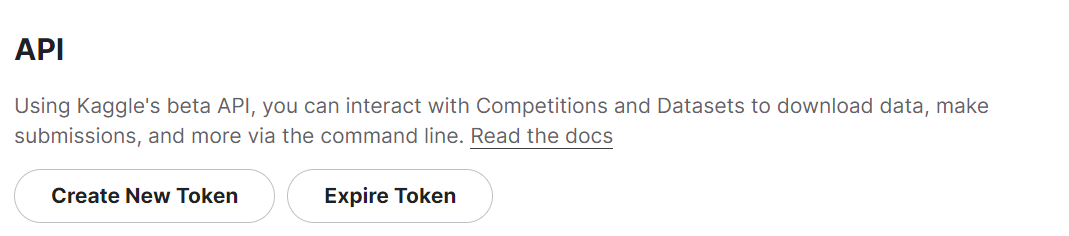
</div>


In [ ]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files(
    "datatattle/covid-19-nlp-text-classification/", path="../data/", unzip=True
)

### 1.2 Carregando os Dados

Os dados foram salvos no formato CSV na pasta `../data` com os nomes `Corona_NLP_train.csv` e `Corona_NLP_test.csv`, para a análise, vamos carregar o conjunto de treino.

In [ ]:
df = pd.read_csv("../data/Corona_NLP_train.csv", encoding="latin1")

## 2. Visão geral 📉 
 
A única coluna com dados faltantes é a `Location`, que possui 8.590 valores nulos. As demais colunas não possuem valores faltantes.

In [ ]:
df.info()

In [ ]:
df["Location"].isnull().sum()

### 2.1 Data de publicação


A coluna `TweetAt` contém a data de publicação do *tweet*, no entanto, ela está no formato de texto, para facilitar a manipulação dos dados, vamos converter essa coluna para o formato `datetime`.


In [ ]:
df.head()

In [ ]:
df.tail()

Com as amostras das datas, podemos observar que a data provavelmente está no formato `dia-mês-ano`, ou seja, o formato `%d-%m-%Y` de acordo a referência do site [strftime.org](https://strftime.org/):

- `%d`: Dia do mês como um número decimal (01-31).
- `%m`: Mês definido como um número decimal (01-12).
- `%Y`: Ano com século como um número decimal.

Antes de fazer a conversão, verificamos se há algum valor que não está no formato esperado.

In [ ]:
df["TweetAt"].str.len().value_counts()

In [ ]:
df["TweetAt"].sample(5)

Como as datas parecem estar no formato esperado, prosseguimos com a conversão.

In [ ]:
df["TweetAt"] = pd.to_datetime(df["TweetAt"], format="%d-%m-%Y")
df.dtypes

Os *tweets* foram publicados entre março e abril de 2020, durante o período de 30 dias, com maior concentração de publicações no final de março e início de abril.

In [ ]:
df["TweetAt"].max() - df["TweetAt"].min()

In [ ]:
df["TweetAt"].describe()

Maior parte dos *tweets* do conjunto de dados foram publicados na quarta-feira, armazenamos a informação do dia da semana em uma nova coluna chamada `DayOfWeek`.

In [ ]:
ax = (
    df["TweetAt"]
    .dt.weekday.value_counts()
    .sort_index()
    .plot(kind="bar", color="skyblue", figsize=(6, 5))
)


ax.set_xlabel("")
ax.set_ylabel("")

ax.set_xticklabels(["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"], rotation=0)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x(), p.get_height() + 20))


ax.text(
    2.5,
    10000,
    "Distribuição de tweets por dia da semana",
    ha="center",
    va="center",
    fontsize=14,
    fontfamily="serif",
    weight="bold",
)

ax.text(
    2.5,
    9300,
    "A maior parte dos tweets foi publicada na quarta-feira",
    ha="center",
    va="center",
    fontsize=12,
    fontfamily="serif",
    color="gray",
    weight="light",
)

plt.tight_layout()

plt.show()

Também removemos a coluna `TweetAt` do conjunto de dados, pois não será mais utilizada.

In [ ]:
df["DayOfWeek"] = df["TweetAt"].dt.day_name()
df["DayOfWeek"] = pd.Categorical(
    df["DayOfWeek"],
    categories=[
        "Sunday",
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
    ],
    ordered=True,
)
df.drop("TweetAt", axis=1, inplace=True)

### 2.2 Localização

Além da data de publicação, podemos notar que a informação de localização não está padronizada, sendo provavelmente preenchida de forma livre pelos usuários, por exemplo, no último *tweet* da amostra, o usuário preencheu com `i love you so much || he/him`, o que não é uma localização válida.

In [ ]:
ax = (
    df["Location"]
    .value_counts()
    .head(10)
    .plot(kind="barh", figsize=(6, 4), width=0.76, color="skyblue")
)
# remover labels do eixo x e y
ax.set_xlabel("")
ax.set_ylabel("")

# remover bordas do gráfico
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# remover ticks do eixo y
ax.tick_params(axis="y", length=0)

ax.set_title("Top 10 localidades com mais tweets")
ax.invert_yaxis()
plt.show()

A maioria dos *tweets* foram publicados nos Estados Unidos, seguido do Reino Unido e Índia. Mas, como a localização não está padronizada, não conseguimos fazer uma análise mais aprofundada. Assim, decidimos remover a coluna `Location` do conjunto de dados. Também removemos as colunas `UserName` e `ScreenName`.

In [ ]:
df.drop(columns=["UserName", "ScreenName", "Location"], inplace=True)
df.sample(5, random_state=42)

In [ ]:
ax = (
    df["Sentiment"]
    .value_counts()
    .plot(
        kind="barh",
        figsize=(6, 4),
        color="lightgrey",
    )
)
ax.set_title("Distribuição de sentimentos")
ax.set_xlabel("")
ax.set_ylabel("")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# remover ticks do eixo y
ax.tick_params(axis="y", length=0)

ax.set_xlim(0, 12000)

# inverter a ordem das barras
ax.invert_yaxis()

# adicionar valores nas barras
for i in ax.patches:
    ax.text(i.get_width() + 100, i.get_y() + 0.3, f"{i.get_width():.0f}")

# destacar a barra com o maior valor
ax.patches[0].set_facecolor("skyblue")
ax.patches[1].set_facecolor("skyblue")

plt.show()

A maior parte dos sentimentos expressos nos *tweets* é `Positive`, seguido de `Negative` e `Neutral`.

### 2.3 Textos dos *tweets*

A coluna `OriginalTweet` contém a mensagem publicada pelo usuário, o comprimento do *tweet* varia de 11 até 355 caracteres, com média de 204, sendo que a maioria das mensagens possuem até 259 caracteres.

In [ ]:
df["OriginalTweet"].str.len().describe()

In [ ]:
ax = (
    df["OriginalTweet"]
    .str.len()
    .plot(kind="hist", bins=100, figsize=(6, 4), color="skyblue")
)
ax.set_title("Distribuição do comprimento dos tweets")
ax.set_xlabel("Comprimento")
ax.set_ylabel("Frequência")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

A mensagem mais curta é:

In [ ]:
print(df.loc[df["OriginalTweet"].str.len().idxmin(), "OriginalTweet"])

Já a mensagem mais longa é:

In [ ]:
print(df.loc[df["OriginalTweet"].str.len().idxmax(), "OriginalTweet"])

Calculamos a quantidade de palavras em cada *tweet* e armazenamos em uma nova coluna chamada `WordCount`. 

In [ ]:
df["WordCount"] = df["OriginalTweet"].str.split().str.len()
df[["WordCount"]].describe()

As postagens do conjunto de dados possuem no máximo 64 palavras, com média de 30 palavras por *tweet*.

In [ ]:
ax = df["WordCount"].plot(kind="hist", bins=100, figsize=(6, 4), color="skyblue")
ax.set_title("Distribuição da contagem de palavras")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

#### 2.3.1 Frequência das palavras

Para visualizar as palavras mais comuns, usamos a biblioteca `wordcloud` que gera a nuvem de palavras com base em suas frequência. No entanto, antes de gerar a nuvem realizamos a padronização do texto, que consiste em:

- Converter todas as palavras para minúsculas.
- Padronizar termos textos especiais, como links, menções a usuários e hashtags.
    - Links: Removemos os links.
    - Menções a usuários: Removemos o caractere `@` e o nome do usuário.
    - Hashtags: Extraímos o texto da hashtag.
- Normalizar o texto, removendo acentos e caracteres especiais, por exemplo, *ração* se torna *racao*.
- Remover pontuações.
- Remover *stopwords*, que são palavras comuns que não possuem significado próprio, como *de*, *a*, *o*, *da*, *do*, entre outras.
- Remover excesso de espaços em branco.

Nós fazemos essa "limpeza" para que a nuvem de palavras seja mais representativa, ou seja, queremos que as palavras mais comuns sejam relevantes para a análise.

In [ ]:
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in STOPWORDS])


texts = (
    df["OriginalTweet"]
    .str.lower()
    .str.replace(r"https\S+|www\S+|https\S+", "", regex=True)
    .str.replace(r"\@\w+", "", regex=True)
    .str.replace(r"\#(\w+)", r"HASHTAG\1", regex=True)
    .str.normalize("NFKD")
    .str.encode("ascii", errors="ignore")
    .str.decode("utf-8")
    .str.translate(PUNCTS_TRANSLATE_TABLE)
    .apply(remove_stopwords)
    .str.replace("HASHTAG", "#")
    .str.replace(r"^[\d\s]+$", "", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)


df["CleanedTweet"] = texts.str.replace(r"\#\w+", "", regex=True).str.strip()
df["Hashtags"] = texts.str.findall(r"#(\w+)").apply(lambda x: " ".join(x))

Após a limpeza, observamos que textos com 0 palavras foram gerados, isso aconteceu porque removemos stopwords, pontuações e outros elementos.

In [ ]:
df["CleanedTweet"].str.split().str.len().describe()

Alguns *tweets* são compostos apenas por menções a usuários, links e hashtags, por isso, após a limpeza, eles ficaram sem palavras.. Amostra de tweets com 0 palavras:

In [ ]:
df.loc[df["CleanedTweet"].str.split().str.len() == 0].sample(10)

In [ ]:
df["CleanedTweet"].str.split().str.len().describe(
    percentiles=[0.01, 0.5, 0.75, 0.9, 0.95]
)

Baseado nas estatísticas, removemos os *tweets* com menos de 3 palavras.

In [ ]:
df = df.loc[df["CleanedTweet"].str.split().str.len() >= 3]
df.reset_index(drop=True, inplace=True)
df.shape

Depois de padronizar o texto, podemos medir a riqueza lexical do texto que é a razão entre *types* (palavras únicas) e *tokens* (palavras totais). A riqueza lexical do conjunto de dados é de 6,26%, ou seja, a cada 100 palavras, cerca de 6 são únicas.

In [ ]:
words = df["CleanedTweet"].str.cat(sep=" ").split()
types = Counter(words)

print(f"Total de palavras: {len(words):,}")
print(f"Tamanho do vocabulário: {len(types):,}")
print(f"Riqueza do corpus: {len(types) / len(words):.2%}")

Outra métrica que podemos obter é a quantidade de palavras únicas no texto, que é de 22.411 palavras, ou seja, elas compõem mais de 50% de todo o vocabulário do conjunto de dados. Essas palavras únicas podem ser erros de digitação, palavras em outros idiomas, entre outros. Na linguística, essas palavras são chamadas de [*hapax legomena* (plural) ou *hapax legomenon* (singular)](https://pt.wikipedia.org/wiki/H%C3%A1pax).

In [ ]:
hapax = set([word for word, count in types.items() if count <= 1])
print(f"Hapax legomena: {len(hapax):,}")
print(f"Proporção de hapax legomena: {len(hapax) / len(types):.2%}")

Nós podemos remover de nosso dataset, as palavras que aparecem apenas uma vez para construir a nuvem, pois elas não são relevantes para a análise.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

text = " ".join(
    [word for word in df["CleanedTweet"].str.cat(sep=" ").split() if word not in hapax]
)

wordcloud = WordCloud(
    width=800, height=480, margin=0, background_color="#FFF"
).generate(text)

ax[0].title.set_text("Todas as palavras")
ax[0].imshow(wordcloud, interpolation="bilinear")
ax[0].axis("off")
ax[0].margins(x=0, y=0)

hashtags_wc = WordCloud(
    width=800, height=480, margin=0, background_color="#FFF"
).generate(df["Hashtags"].str.replace(r"\s+", " ", regex=True).str.cat(sep=" ").strip())

ax[1].title.set_text("Hashtags")
ax[1].imshow(hashtags_wc, interpolation="bilinear")
ax[1].axis("off")
ax[1].margins(x=0, y=0)

plt.show()

### 2.4 Sentimentos

A coluna `Sentiment` contém o sentimento associado ao *tweet*, que pode ser `Positive`, `Negative`, `Neutral`, `Extremely Positive` ou `Extremely Negative`. A maior parte dos *tweets* expressa sentimentos `Positive`, seguido de `Negative` e `Neutral`.

In [ ]:
ax = df["Sentiment"].value_counts().plot(kind="barh", figsize=(6, 4), color="lightgrey")

ax.set_title("Distribuição de sentimentos")
ax.set_xlabel("")
ax.set_ylabel("")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# remover ticks do eixo y
ax.tick_params(axis="y", length=0)

ax.set_xlim(0, 12000)

# inverter a ordem das barras
ax.invert_yaxis()

# adicionar valores nas barras
for i in ax.patches:
    ax.text(i.get_width() + 100, i.get_y() + 0.3, f"{i.get_width():.0f}")

# destacar a barra com o maior valor
ax.patches[0].set_facecolor("skyblue")

plt.show()

In [ ]:
df["Sentiment"] = pd.Categorical(
    df["Sentiment"],
    categories=[
        "Extremely Negative",
        "Negative",
        "Neutral",
        "Positive",
        "Extremely Positive",
    ],
    ordered=True,
)

## 3. Análise exploratória dos dados 📊

Na seção anterior, fizemos uma análise superficial dos dados, agora vamos explorar mais a fundo as mensagens publicadas no X (antigo Twitter) durante a pandemia da Covid-19. 

### 3.1 Relação entre sentimentos e demais variáveis

Vamos analisar a relação entre os sentimentos expressos nos *tweets* e as demais variáveis do conjunto de dados.

- Dia da semana
- Hashtags
- Quantidade de Palavras

#### 3.1.1 Dia da semana

Começamos a seção explorando a relação entre dia da semana e sentimentos, a hipótese que queremos validar é se há maior ocorrência de sentimentos negativos em dias úteis, por exemplo, segunda-feira, e maior ocorrência de sentimentos positivos em dias de descanso, como sábado e domingo.

In [ ]:
sentiment_by_day = (
    df.groupby("DayOfWeek", observed=True)["Sentiment"]
    .value_counts(normalize=True)
    .unstack()
)

sentiments_labels = [
    "Extremamente\nNegativo",
    "Negativo",
    "Neutro",
    "Positivo",
    "Extremamente\nPositivo",
]

sentiment_colors = [
    "#C3514E",
    "#e39691",
    "#A6A6A5",
    "#8db53f",
    "#0C8040",
]

ax = sentiment_by_day.plot.line(
    marker="o",
    figsize=(13, 6),
    color=sentiment_colors,
)

# remover linhas do topo e da direita
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# incluir nome antes de cada linha
for i, line in enumerate(ax.lines):
    y = line.get_ydata()[-1]
    label = line.get_label()
    if label in ["Extremely Positive", "Neutral"]:
        continue
    ax.text(
        -0.6,
        y - 0.01,
        sentiments_labels[i],
        fontsize=13,
        fontfamily="serif",
        ha="center",
        color=sentiment_colors[i],
    )


# remover legenda
ax.legend().remove()

# Legendas para os sentimentos que se sobrepõem
ax.text(
    -0.6,
    0.185,
    "Neutro",
    fontsize=14,
    fontfamily="serif",
    ha="center",
    color=sentiment_colors[2],
)

ax.text(
    -0.6,
    0.16,
    "Extremamente\nPositivo",
    fontsize=13,
    fontfamily="serif",
    ha="center",
    color=sentiment_colors[-1],
)

# mudar cor dos eixos
ax.tick_params(axis="x", colors="#646369")
ax.tick_params(axis="y", colors="#646369")

# remover traços do eixo x
ax.tick_params(axis="x", length=0)

# Mudar faixa de valores do eixo y
plt.yticks(
    ticks=[0.1, 0.12, 0.15, 0.19, 0.23, 0.26, 0.29, 0.35],
    labels=["10%", "12%", "15%", "19%", "23%", "26%", "29%", "35%"],
    fontsize=12,
    fontfamily="serif",
    color="#646369",
)

# Modificar faixa de valores do eixo x
plt.xticks(
    ticks=[-1.5, -1] + sentiment_by_day.index.codes.tolist(),
    labels=[
        "",
        "",
        "Domingo",
        "Segunda",
        "Terça",
        "Quarta",
        "Quinta",
        "Sexta",
        "Sábado",
    ],
    rotation=0,
    fontsize=13,
    fontfamily="serif",
    color="#646369",
)


# adicionar linhas verticais na terça e na sexta
ax.axvline(2, ymax=0.85, color="#76787B", linewidth=1)
ax.axvline(5, ymax=0.85, color="#76787B", linewidth=1)

# adicionar texto entre as linhas verticais
ax.text(
    2.1,
    0.32,
    "$\\bf{Terça\ e\ Sexta}$ foram os dias que tiveram\ndeclínio no número de tweets positivos e\naumento no número de tweets negativos",
    fontsize=12,
    fontfamily="serif",
    ha="left",
    color="#76787B",
)

ax.text(
    -2.25,
    0.4,
    "Mensagens positivas são mais frequentes",
    fontsize=20,
    fontfamily="serif",
    ha="left",
    color="#646369",
    weight="bold",
)

ax.text(
    -2.25,
    0.37,
    "No fim de semana houve um aumento no número\nde tweets extremamentes positivo",
    fontsize=14,
    fontfamily="serif",
    ha="left",
    color="#929497",
)

ax.set_xlabel("")
ax.set_ylabel("Proporção de tweets", fontsize=14, fontfamily="serif", color="#646369")
ax.yaxis.set_label_coords(-0.075, 0.8)

plt.show()

Ao analisar o percentual de sentimentos no decorrer da semana, podemos confirmar a hipótese de que no final de semana há um aumento na quantidade de sentimentos positivos e uma diminuição na quantidade de sentimentos negativos. E a quantidade de sentimentos neutros se manteve semelhante ao longo da semana.

#### 3.1.2 Hashtags

As hashtags são palavras ou frases precedidas pelo símbolo `#`, elas são utilizadas para categorizar mensagens e facilitar a busca por conteúdo relacionado. No Twitter, as hashtags são muito utilizadas para expressar sentimentos, opiniões e informações sobre um determinado assunto. Para visualizar a nuvem de palavrasm retiramos palavras que são variações de `covid`, `coronavirus` e `covid19`, pois elas são as palavras mais comuns no conjunto de dados.

In [ ]:
stopwords = {
    "covid",
    "coronavirus",
    "covid19",
    "corona",
    "coranaviru",
    "covid2019",
    "coronacrisis",
    "coronavirusoutbreak",
    "coronaviruspandemic",
    "coronavirusupdate",
    "coronavirusupdates",
    "coronavirususa",
    "coronavirusuk",
    "covid19uk",
    "covid19usa",
    "19",
    "2019",
    "amp",  # provavelmente &amp;
}

sentiments = [
    "Extremely Negative",
    "Negative",
    "Neutral",
    "Positive",
    "Extremely Positive",
]

fig = plt.figure(figsize=(24, 10))
specs = gridspec.GridSpec(nrows=2, ncols=3, figure=fig)

for sentiment, spec in zip(sentiments, specs):
    ax = fig.add_subplot(spec)
    ax.set_title(sentiment, fontsize=12, fontfamily="serif", color="#646369")

    # remover stopwords
    text = df.loc[df["Sentiment"] == sentiment, "Hashtags"].str.cat(sep=" ")
    text = " ".join([word for word in text.split() if word not in stopwords])

    wordcloud = WordCloud(
        width=800, height=480, margin=0, background_color="#FFF"
    ).generate(text)

    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.margins(x=0, y=0)


fig.text(
    0.5,
    0.95,
    "Wordclouds das hashtags por sentimento",
    fontsize=16,
    fontfamily="serif",
    ha="center",
    color="#646369",
)

plt.show()

Na nuvem gerada, vemos a repetição de variáveis palavras como "toiletpaper", "panicbuying" e "socialdistancing", que são palavras relacionadas a pandemia da Covid-19.

In [ ]:
fig, ax = plt.subplots(5, 1, figsize=(12, 12), dpi=150)

for i, sentiment in enumerate(sentiments):
    text = " ".join(
        [
            word
            for word in df.loc[df["Sentiment"] == sentiment, "Hashtags"]
            .str.cat(sep=" ")
            .split()
            if word not in stopwords
        ]
    )
    words = text.split()
    types = Counter(words)

    df_types = pd.DataFrame(types.most_common(10), columns=["word", "frequency"])

    ax[i].bar(
        df_types["word"],
        df_types["frequency"],
        color=sentiment_colors[i],
    )

    ax[i].set_title(sentiment, fontsize=12, fontfamily="serif", color="#646369")
    ax[i].set_ylabel("Frequência", fontsize=10, fontfamily="serif", color="#646369")
    ax[i].tick_params(axis="x", labelrotation=45)

fig.text(
    0.5,
    1.025,
    "Hashtags mais frequentes por sentimento",
    fontsize=16,
    fontfamily="serif",
    ha="center",
    color="#646369",
)

plt.tight_layout()
plt.show()

Ao colocar em forma de gráfico de barras, vemos que esses *tweets* relatam muito sobre pânico de comprar papel higiênico, distanciamento social e ficar em casa. Notamos também que há maior presença de hashtags relacionadas a ficar em casa nos sentimentos positivos. Nas negativas, há maior presença de hashtags relacionadas a compras de pânico.

#### 3.1.3 Quantidade de palavras

Por fim, analisamos a relação entre a quantidade de palavras e os sentimentos expressos nos *tweets*. A hipótese que queremos validar é se *tweets* com maior quantidade de palavras expressam sentimentos mais negativos.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

sentiment_by_wordcount = df.groupby("Sentiment", observed=True)["WordCount"].mean()


sentiment_by_wordcount.plot(kind="barh", color="skyblue", ax=ax[0], width=0.8)
ax[0].set_title("Média de palavras por sentimento")
ax[0].set_ylabel("")
ax[0].set_xlabel("Média de palavras")
for i in ax[0].patches:
    ax[0].text(i.get_width() + 0.1, i.get_y() + 0.25, f"{i.get_width():.2f}")

ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)


sentiment_by_wordcount = df.groupby("Sentiment", observed=True)["WordCount"].median()
sentiment_by_wordcount.plot(kind="barh", color="skyblue", ax=ax[1], width=0.8)
ax[1].set_title("Mediana de palavras por sentimento", fontsize=12, fontfamily="serif")
ax[1].set_ylabel("")
ax[1].set_xlabel("Mediana de palavras")

for i in ax[1].patches:
    ax[1].text(i.get_width() + 0.1, i.get_y() + 0.25, f"{i.get_width():.2f}")

ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

Os *tweets* extremamente positivos e extremamente negativos possuem maior quantidade de palavras, enquanto os *tweets* neutros possuem menor quantidade de palavras.

#### 3.1.4 Textos dos *tweets*

Agora, vamos analisar a relação entre os sentimentos expressos nos *tweets* e as mensagens publicadas pelos usuários. 


Partes do discurso (POS) são as palavras que desempenham diferentes funções em uma frase. Oito ou nove classes gramaticais são comumente listadas:

- Substantivos
- Verbos
- Adjetivos
- Advérbios
- Pronomes
- Preposições
- Conjunções 
- Interjeições.

Algumas classificações modernas definem outras classes além destas. Vamos analisar a distribuição das partes do discurso nos *tweets* usando a biblioteca `spacy`.	

In [ ]:
docs = nlp.pipe(
    df["CleanedTweet"],
)

pos_tags = Counter()

for doc in tqdm(docs, total=len(df)):
    pos_tags.update([token.pos_ for token in doc])

pos_tags = pd.Series(pos_tags).sort_values(ascending=False)

Nos *tweets* temos muito substantivos, seguido em menor quantidade por verbos, adposições e nomes próprios.

In [ ]:
ax = pos_tags.plot(kind="barh", figsize=(6, 4), color="skyblue")
ax.set_title("Distribuição das classes gramaticais")
ax.set_xlabel("Classe gramatical")
ax.set_ylabel("Frequência")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x(), p.get_height() + 20))

# inverter a ordem das barras
ax.invert_yaxis()

plt.show()

In [ ]:
docs = nlp.pipe(df["CleanedTweet"])
most_common_pos = {pos: spacy.explain(pos) for pos in pos_tags.head(10).index.tolist()}

df.loc[:, list(most_common_pos.values())] = 0

for idx, doc in tqdm(enumerate(docs), total=len(df)):
    pos = [token.pos_ for token in doc]
    pos_count = Counter(pos)
    for key in most_common_pos:
        df.loc[idx, most_common_pos[key]] = pos_count[key]

Ao analisar por sentimentos, vemos que a quantidade de classes gramaticais é semelhante, sendo que crescem a medida que o sentimento se torna mais extremo.

In [ ]:
pos_by_sentiments = df.groupby("Sentiment", observed=True)[
    list(most_common_pos.values())
].mean()

fig = plt.figure(figsize=(12, 6))

plt.imshow(pos_by_sentiments, cmap="Blues", aspect="auto")

plt.colorbar()

plt.xticks(range(10), pos_by_sentiments.columns, rotation=45)
plt.yticks(range(5), pos_by_sentiments.index)

plt.title("Média de classes gramaticais por sentimento")

for i in range(5):
    for j in range(10):
        plt.text(
            j,
            i,
            f"{pos_by_sentiments.iloc[i, j]:.2f}",
            ha="center",
            va="center",
            color="white" if pos_by_sentiments.iloc[i, j] > 5 else "black",
        )


# remover ticks
plt.tick_params(axis="both", length=0)

# remover bordas
for spine in plt.gca().spines.values():
    spine.set_visible(False)


plt.show()

Por fim, como uma última análise básica, vamos verificar a distribuição das palavras mais comuns nos *tweets* por sentimentos.

In [ ]:
stopwords = {
    "covid",
    "coronavirus",
    "covid19",
    "corona",
    "coranaviru",
    "covid2019",
    "coronacrisis",
    "coronavirusoutbreak",
    "coronaviruspandemic",
    "coronavirusupdate",
    "coronavirusupdates",
    "coronavirususa",
    "coronavirusuk",
    "covid19uk",
    "covid19usa",
    "19",
    "2019",
    "amp",  # provavelmente &amp;
}

sentiments = [
    "Extremely Negative",
    "Negative",
    "Neutral",
    "Positive",
    "Extremely Positive",
]

fig = plt.figure(figsize=(24, 10))
specs = gridspec.GridSpec(nrows=2, ncols=3, figure=fig)

for sentiment, spec in zip(sentiments, specs):
    ax = fig.add_subplot(spec)
    ax.set_title(sentiment, fontsize=12, fontfamily="serif", color="#646369")

    # remover stopwords
    text = df.loc[df["Sentiment"] == sentiment, "CleanedTweet"].str.cat(sep=" ")
    text = " ".join([word for word in text.split() if word not in stopwords])

    wordcloud = WordCloud(
        width=800, height=480, margin=0, background_color="#FFF"
    ).generate(text)

    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.margins(x=0, y=0)


fig.text(
    0.5,
    0.95,
    "Wordclouds dos tweets por sentimento",
    fontsize=16,
    fontfamily="serif",
    ha="center",
    color="#646369",
)

plt.show()

Vemos que em sentimentos extremamente negativos a presença muito forte das palavras `crisis`, `people` e `food`, mas no geral, os temas falados são muito semelhantes. Os termos `grocery`, `store` apareceram mais nos sentimentos positivos.

In [ ]:
fig, ax = plt.subplots(5, 1, figsize=(12, 12), dpi=150)

for i, sentiment in enumerate(sentiments):
    text = " ".join(
        [
            word
            for word in df.loc[df["Sentiment"] == sentiment, "CleanedTweet"]
            .str.cat(sep=" ")
            .split()
            if word not in stopwords
        ]
    )
    words = text.split()
    types = Counter(words)

    df_types = pd.DataFrame(types.most_common(10), columns=["word", "frequency"])

    ax[i].bar(
        df_types["word"],
        df_types["frequency"],
        color=sentiment_colors[i],
    )

    ax[i].set_title(sentiment, fontsize=12, fontfamily="serif", color="#646369")
    ax[i].set_ylabel("Frequência", fontsize=10, fontfamily="serif", color="#646369")
    ax[i].tick_params(axis="x", labelrotation=45)

fig.text(
    0.5,
    1.025,
    "Palavras mais frequentes por sentimento",
    fontsize=16,
    fontfamily="serif",
    ha="center",
    color="#646369",
)

plt.tight_layout()
plt.show()